<a href="https://colab.research.google.com/github/Os-688/Challenge-Oracle-One/blob/main/Proyecto_robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ° 1 Configurando el ambiente:

## ° 1.1 Instanciando variables:



In [38]:
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision


##° 1.2 Descargando librerias:

In [2]:
pip install requests requests_cache requests_ratelimiter pyrate_limiter beautifulsoup4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 6.5 MB/s eta 0:00:00


In [3]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install


--2023-10-27 21:25:34--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-10-27 21:25:35--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-10-27 21:25:35--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [4]:
!pip install TA-Lib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TA-Lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=2017495 sha256=fcb826b0f340efcef8f6d2c9d52ed68934807f419b8b30b4aa877297e5c838ed
  Stored in directory: /root/.cache/pip/wheels/66/54/9d/10bfd00931c0c993f373269d350635df520b5064e5290a9d94
Successfully built TA-Lib


Revision de librerias:

In [5]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')
!pip show yfinance | grep 'Name\|Version'
print('------')
!pip show lxml  | grep 'Name\|Version'
print('------')
!pip show requests_ratelimiter  | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1
------
Name: yfinance
Version: 0.2.31
------
Name: lxml
Version: 4.9.3
------
Name: requests-ratelimiter
Version: 0.4.2


Importando librerias:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import re
import time
import matplotlib.font_manager
import talib
from IPython.display import clear_output
from bs4 import BeautifulSoup
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

# ° 2 Obtención de datos:

## ° 2.1 Creando la funcion para obtener el dataframe con el historico del bitcoin:

In [7]:
def importar_base_bitcoin():
  global df_bitcoin

# Otra manera de realizar actualizaciones cada 5 minutos pero en este caso acompaña, porque gasta menos memoria la funcion time.sleep().
  session = CachedLimiterSession(
      limiter=Limiter(RequestRate(1, Duration.MINUTE*5)),  # maximo 1 request por 5 minutos
      bucket_class=MemoryQueueBucket,
      backend=SQLiteCache("yfinance.cache"),
  )

  BTC = yf.Ticker("BTC-USD")
  df_bitcoin = BTC.history(period="7d", interval="5m")





In [8]:
importar_base_bitcoin()


## ° 2.2 Creando la funcion para obtener la tendencia con web scraping:

In [9]:
def extraer_tendencias():
  #Indicacion para usar variables globales dentro de una funcion

  global tendencia, precio_actual

  # URL de la página web a raspar
  url = 'https://coinmarketcap.com/'

  header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0"}

  # Realizando una solicitud HTTP para obtener el contenido de la página
  response = requests.get(url, headers = header)

  # Creando variable para asignar y leer la tendencia
  tend = None

  # Verificando si la solicitud fue exitosa

  if response.status_code == 200:

      # Analizando el contenido HTML de la página utilizando BeautifulSoup

      soup = BeautifulSoup(response.content, 'lxml')

      # Se obtienen los datos en bruto

      valor_actual = soup.findAll('div', {'class':'sc-a0353bbc-0 gDrtaY'})
      valor_actual_filtrado = [valor.find('a', {'href':'/currencies/bitcoin/#markets'}) for valor in valor_actual if valor.find('a', {'href':'/currencies/bitcoin/#markets'}) is not None]

      tend = soup.select("td > span > span")

      # Conversion de las variables, conversion a double y se revisa que se haya encontrado los valores.

      try:

        # Se obtiene el elemento de las listas y se convierten a textos
        texto = valor_actual[0].get_text()
        tag = tend[0]
        texto1 = str(tag)

        # Filtrando el texto a solo el numero, convirtiendo texto a double.

        precio_crudo = re.split(r"[$,]", texto)
        precio_crudo = "".join(precio_crudo).strip()

        precio_actual = float(precio_crudo)

      except ValueError as ve:
        print("Error al convertir a número decimal:")
        print(ve)
      except Exception as e:
        print("No se pudo acceder a los datos, hay un error en la obtencion de los datos. ")
        print(e)

      # filtrando el texto de la tag para obtener solo el nombre de la clase el cual indicara si esta en alta o baja

      tendencia_cruda = texto1.split('"')[1]

      # Creando la logica para la variable tendencia

      if tendencia_cruda == "icon-Caret-up":
        tendencia = "alta"
      elif tendencia_cruda == "icon-Caret-down":
        tendencia = "baja"
  else:
      print('No se pudo acceder a la página. Código de estado:', response.status_code)


In [10]:
extraer_tendencias()

In [11]:

#Codigo sintetizado

def obtener_datos(url):
    try:
        header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0"}
        response = requests.get(url, headers=header)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'lxml')
            valor_actual = soup.find_all('div', {'class': 'sc-a0353bbc-0 gDrtaY'})

            # Filtra los valores que cumplen con ciertas condiciones
            valor_actual_filtrado = [valor.find('a', {'href': '/currencies/bitcoin/#markets'}) for valor in valor_actual if valor.find('a', {'href': '/currencies/bitcoin/#markets'}) is not None]

            tend = soup.select("td > span > span")
            return valor_actual_filtrado, tend
        else:
            return None, None
    except Exception as e:
        print("No se pudo acceder a los datos. Error:", e)
        return None, None

def extraer_datos():

    global tendencia, precio_actual

    url = 'https://coinmarketcap.com/'
    valor_actual_filtrado, tend = obtener_datos(url)

    if valor_actual_filtrado and tend:
        try:
            texto = valor_actual_filtrado[0].get_text()
            precio_crudo = re.sub(r'[$,]', '', texto)
            precio_actual = float(precio_crudo)
            print("Valor como número decimal:", precio_actual)

            tendencia_cruda = str(tend[0])
            if "icon-Caret-up" in tendencia_cruda:
                tendencia = "alta"
            elif "icon-Caret-down" in tendencia_cruda:
                tendencia = "baja"
            else:
                tendencia = "desconocida"
            print("Tendencia:", tendencia)
        except ValueError as ve:
            print("Error al convertir a número decimal:", ve)
    else:
        print('No se pudo acceder a la página.')

if __name__ == "__main__":
    extraer_datos()


Valor como número decimal: 33819.61
Tendencia: alta


# ° 3 Limpieza de datos

In [40]:
def limpieza_datos():
  global media_bitcoin

  # Copiando el dataframe
  df_bitcoin_limpio = df_bitcoin.copy()

  # Eliminando indices duplicados
  duplicados = df_bitcoin.index.duplicated(keep= "First")
  df_bitcoin_limpio = df_bitcoin_limpio[~duplicados]

  # Eliminando valores nulos de close
  valores_nulos = df_bitcoin_limpio["Close"].isnull()
  df_bitcoin_limpio.dropna(subset=["Close"],inplace=True)

  # Eliminando valores iguales a 0 de volume
  mascara = df_bitcoin_limpio['Volume'] > 0
  df_bitcoin_limpio = df_bitcoin_limpio[mascara]

  # Identificando los outliers
  q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  iqr = q3 - q1
  umbral_superior = q3 + 1.5 * iqr
  umbral_inferior = q1 - 1.5 * iqr

  # Filtrando para eliminar los outliers
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= umbral_inferior) & (df_bitcoin_limpio['Close'] <= umbral_superior)]

  # Calculando los cuartiles Q1 y Q3 nuevamente
  q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)

  # Filtrando el DataFrame para seleccionar registros entre el primer cuartil y el tercer cuartil
  df_filtrado = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= q1) & (df_bitcoin_limpio['Close'] <= q3)]

  # Obtencion de la media de close del filtrado
  media_bitcoin = df_filtrado['Close'].mean()

In [ ]:
# Haciendo grafico boxplot para visualizar los datos:

df_bitcoin_limpio = df_bitcoin.copy()

duplicados = df_bitcoin.index.duplicated(keep= "First")
df_bitcoin_limpio = df_bitcoin_limpio[~duplicados]

valores_nulos = df_bitcoin_limpio["Close"].isnull()
df_bitcoin_limpio.dropna(subset=["Close"], inplace=True)

mascara = df_bitcoin_limpio['Volume'] > 0
df_bitcoin_limpio = df_bitcoin_limpio[mascara]

# Creando un gráfico boxplot para visualizar
plt.figure(figsize=(8, 4))
plt.boxplot(df_bitcoin_limpio['Close'], vert=False)
plt.title("Boxplot Precios de Bitcoin")
plt.show()

print("------------------------")
print("------------------------")


In [42]:
limpieza_datos()

In [43]:
media_bitcoin

32296.667543608568

In [ ]:
df_bitcoin.sample(10)

In [ ]:
duplicados = df_bitcoin.index.duplicated(keep= "First")
type(duplicados)

In [ ]:
valores_nulos = df_bitcoin["Close"].isnull()
len(valores_nulos)

In [ ]:
len(df_bitcoin["Close"])

In [ ]:
mascara = df_bitcoin['Volume'] > 0

mascara


# ° 4 Tomar decisiones

## ° 4.1 Nuevas variables para la decision:

In [50]:
BTC = yf.Ticker("BTC-USD")
data = BTC.history(period="50d", interval="5m")

# Calculando el SMA de 50 días
sma_50_df = talib.SMA(data['Close'], timeperiod=50)

# Calculando el RSI de 14 días
rsi_df = talib.RSI(data['Close'], timeperiod=14)

sma_50 = sma_50_df.iloc[-1]
rsi = rsi_df.iloc[-1]

## ° 4.2 Algoritmo de decision:

In [51]:
def tomar_decisiones():
    global algoritmo_decision

    # Criterios de decisión
    if (precio_actual >= media_bitcoin and tendencia == 'baja') or (rsi > 70 and precio_actual > sma_50):
        algoritmo_decision = 'Vender'
    elif (precio_actual < media_bitcoin and tendencia == 'alta') or (rsi < 30 and precio_actual < sma_50):
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'NONE'

# Llamando a la función para tomar la decisión
tomar_decisiones()


In [52]:
#Comprobación del funcionamiento
print(tendencia, precio_actual, media_bitcoin,algoritmo_decision)

alta 33819.61 32296.667543608568 NONE


# ° 5 Visualización

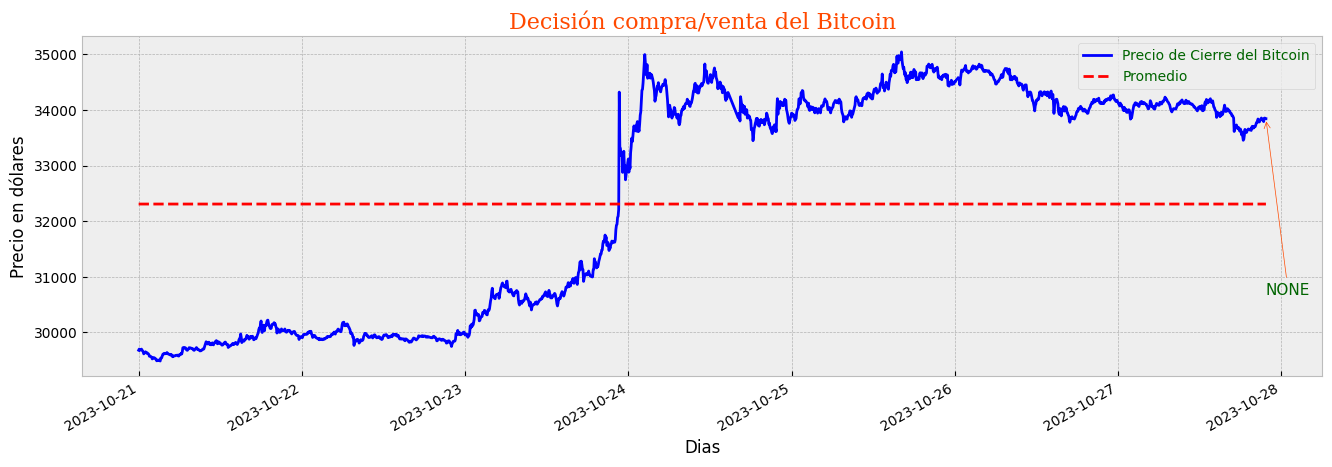

In [61]:
def visualizacion():
    # Accediendo al DataFrame original
    global df_bitcoin

    # Agregando la columna "Promedio" al DataFrame original
    df_bitcoin['Promedio'] = media_bitcoin

    # Configurando el tamaño del grafico
    plt.figure(figsize=(16, 5))

    # Configurando el estilo del gráfico
    plt.style.use('bmh')

    # Agregando una rejilla
    plt.grid(True)

    # Agregando un título al gráfico
    title_font = {'family': 'serif', 'size': 16, 'weight': '100'}
    plt.title("Decisión compra/venta del Bitcoin", color='#FF4900', fontdict=title_font)

    # Dibujando una línea con los datos de Close
    df_bitcoin['Close'].plot(label='Precio de Cierre del Bitcoin', color='blue')

    # Dibujando una línea con los datos de Promedio
    df_bitcoin['Promedio'].plot(label='Promedio', color='red', linestyle='--')

    # Agregando etiquetas a los ejes x e y
    plt.xlabel("Dias")  # Etiqueta del eje x
    plt.ylabel("Precio en dólares")  # Etiqueta del eje y

    # Mostrando la decisión calculada en el gráfico
    plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
                 xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[4] + 990),
                 arrowprops=dict(arrowstyle='->', color='#FF4900'),
                 fontsize=11,
                 color="darkgreen")

    # Mostrando el gráfico
    plt.legend(labelcolor='darkgreen') # Muestra las labels en una leyenda, ya que son dos.
    plt.show()

# Llamando a la función para visualizar el gráfico
visualizacion()


In [54]:

font_list = matplotlib.font_manager.findSystemFonts()

for font_path in font_list:
    print(font_path)

/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf
/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf
/usr/share/fonts/truetype/liberation/

# ° 6 Automatización

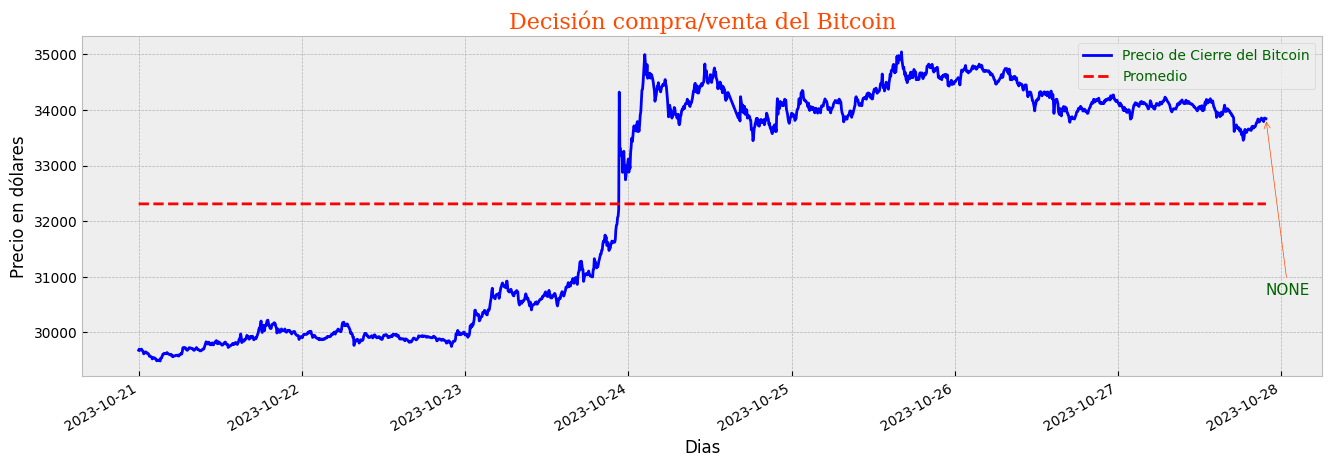

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)